In [93]:
from keras.models import Model
from keras.layers import Input, Conv3D, ConvLSTM2D, ConvLSTM3D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [57]:
def load_npy(folder): # used for MOD14A2, MOD13Q1
    mod14 = folder + '/MOD14A2*.npy'
    mod13 = folder + '/MOD13Q1*.npy'
    mod14g = glob.glob(mod14)
    mod13g = glob.glob(mod13)
    
    times = min(len(mod14g), len(mod13g))
    if times < frames:
        return
    res = np.zeros(shape=(1, times, dims, dims, channels))
    for i in range(times):
        arr14 = np.load(mod14g[i])
        arr13 = np.load(mod13g[i])
        if (arr14.shape != (dims, dims)) or (arr13.shape != (dims, dims)):
            return
        arr14 = arr14[np.newaxis, np.newaxis, :, :]
        arr13 = arr13[np.newaxis, np.newaxis, :, :]
        res[:, i, :, :, 0] = arr14
        res[:, i, :, :, 1] = arr13

    print(res.shape)
    return res

In [113]:
dims = 50
frames = 11
channels = 2

path = '/home/fun/wildfire_data/*'
files = glob.glob(path)
file_list = np.array([])
data = np.zeros(shape=(1, frames, dims, dims, channels))

for file in files:
    prof = file + '/profile.json'
    try:
        f = open(prof)
        info = json.load(f)
        if info['info']['acres_burned'] >= 1000:
            arr = load_npy(file) # many fires (~30) do not have an acres_burned value, instead it is an empty string "".
                                 # these fires are minor and only last around 1 or 2 months.
                                 # for now, doing a try except to get around this is good enough.
            arr = arr[:, -frames:, :, :, :]
            data = np.append(data, arr, axis=0)
            file_list = np.append(file_list, file)
    except:
        continue

data = np.delete(data, 0, axis=0)
print("FINAL SHAPE:", data.shape)

during = data[:, 0:frames-1, :, :, :] # all but last frame
#during = during[:, :, :, :, np.newaxis]

after = data[:, 1:, :, :, :] # missing first frame (shifted forward 1)
#after = after[:, :, :, :, np.newaxis]
print("x_train shape:", during.shape)
print("y_train shape:", after.shape)

(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 11, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 12, 50, 50, 2)
(1, 13, 50, 50, 2)
(1, 12, 50, 

In [114]:
inp = Input(shape=(None, 50, 50, 2))

x = ConvLSTM2D(filters=64, kernel_size=(5, 5), 
                   padding='same', return_sequences=True)(inp)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(5, 5),
                   padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

x = Conv3D(filters=channels, kernel_size=(5, 5, 5),
               activation='softmax',
               padding='same', data_format='channels_last')(x)

model = Model(inp, x)
model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, None, 50, 50, 2)  0         
                             ]                                   
                                                                 
 conv_lstm2d_47 (ConvLSTM2D)  (None, None, 50, 50, 64)  422656   
                                                                 
 batch_normalization_44 (Bat  (None, None, 50, 50, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_48 (ConvLSTM2D)  (None, None, 50, 50, 64)  819456   
                                                                 
 batch_normalization_45 (Bat  (None, None, 50, 50, 64)  256      
 chNormalization)                                                
                                                           

In [ ]:
model.fit(during, # timestamps during wildfire
        after, # predictions (timestamps to predict)
        batch_size=20,
        epochs=10,
        validation_split=0.20, 
       )

Epoch 1/10
5/8 [=================>............] - ETA: 3:38 - loss: -5779.0386

(11, 50, 50, 2)
0
1
2
3
4


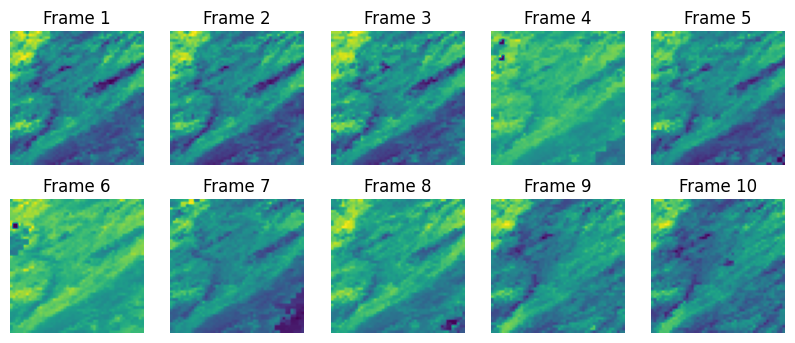

In [112]:
print(example.shape)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, ax in enumerate(axes[0]):
    print(idx)
    ax.imshow(example[idx, :, :, 1])
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(example[idx+5, :, :, 1])
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

SAMPLE: /home/fun/wildfire_data/Fish_Fire_2013-08-24
(5, 50, 50, 1) (6, 50, 50, 1)
1/1 [==============================] - 0s 77ms/step


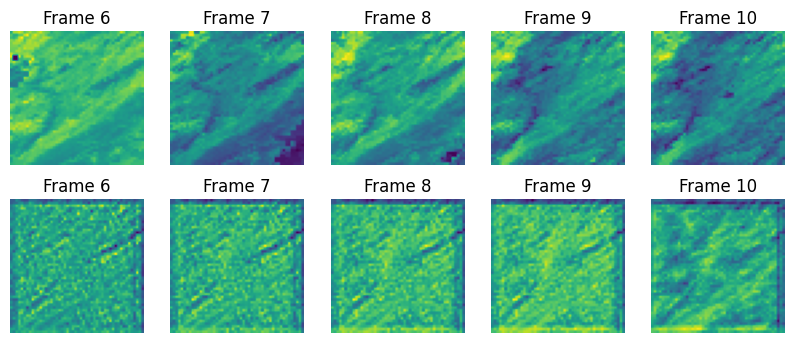

In [80]:
n = np.random.choice(range(len(data)), size=1)[0]
print("SAMPLE:", file_list[n])

example = data[n]
sample = example[:5, :, :, 1]
sample = sample[..., np.newaxis]
actual = example[5:, :, :, 1]
actual = actual[..., np.newaxis]
print(sample.shape, actual.shape)


for _ in range(5):
    new_prediction = model.predict(np.expand_dims(sample, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((sample, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(actual[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

new_frames = sample[5:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_prediction[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

plt.show()

In [18]:
steps = 6
idx = 105

preds = data[idx][:steps, :, :, 1]
preds = preds[:, :, :, np.newaxis]
print(preds.shape)
for j in range(frames-steps):
    new_pos = seq.predict(preds[np.newaxis, :, :, :, :])
    new = new_pos[:, -1, :, :, :]
    preds = np.concatenate((preds, new), axis=0) # adds +1 to the first dimension in each loop cycle"

(6, 50, 50, 1)
1/1 [==============================] - 0s 157ms/step


(12, 50, 50)


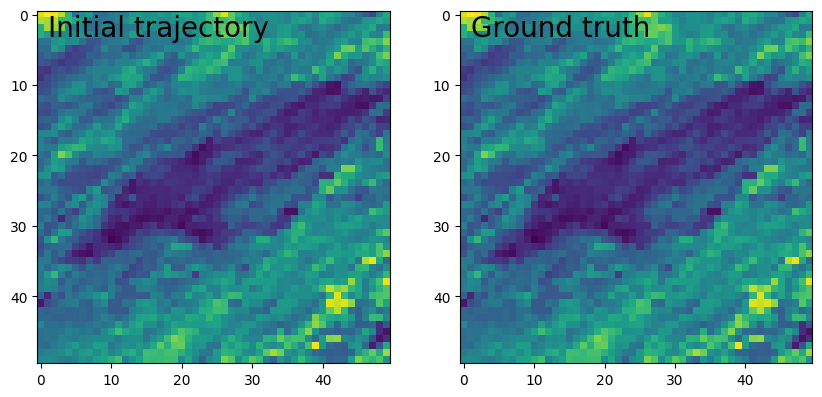

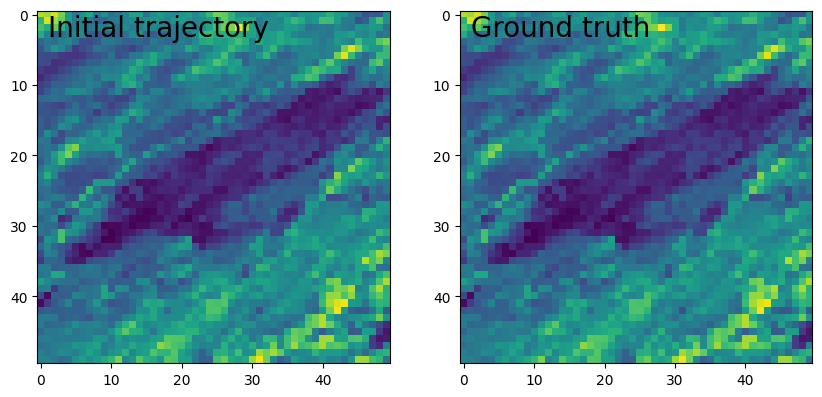

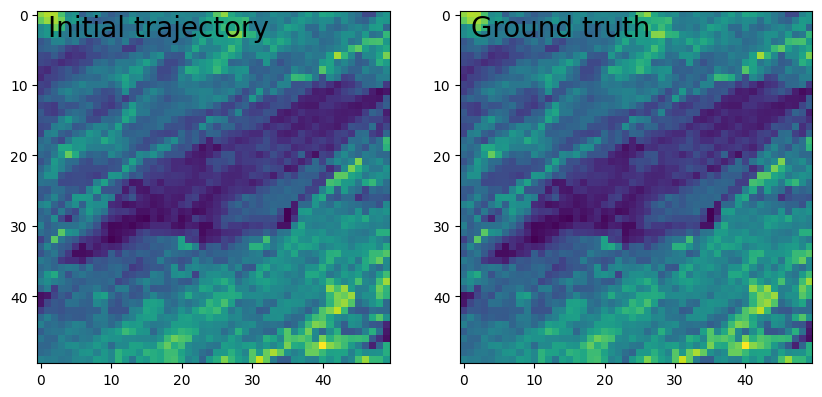

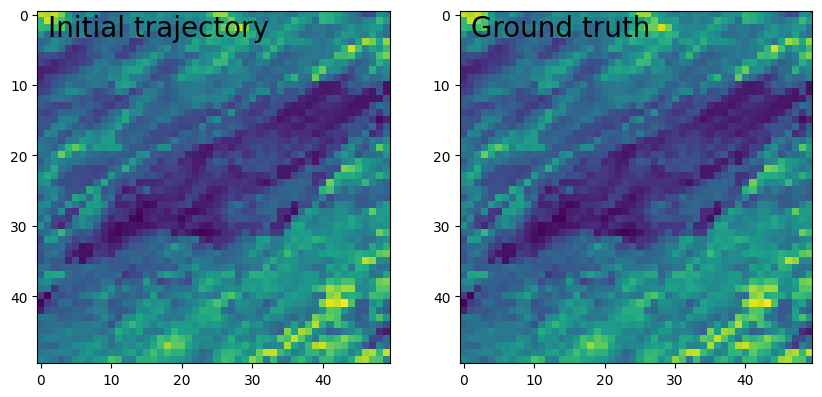

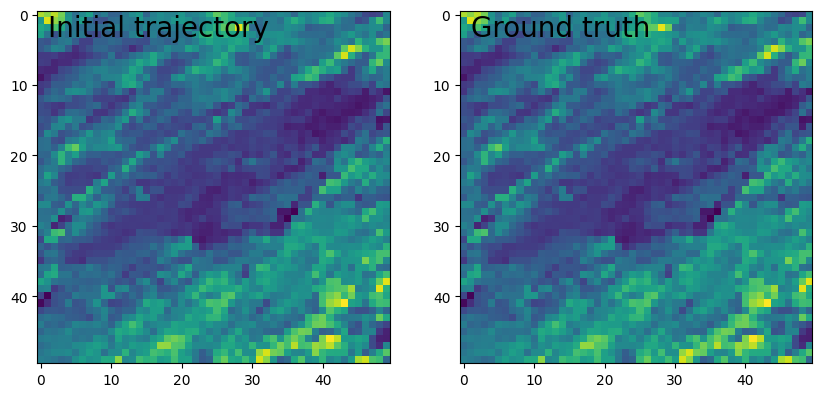

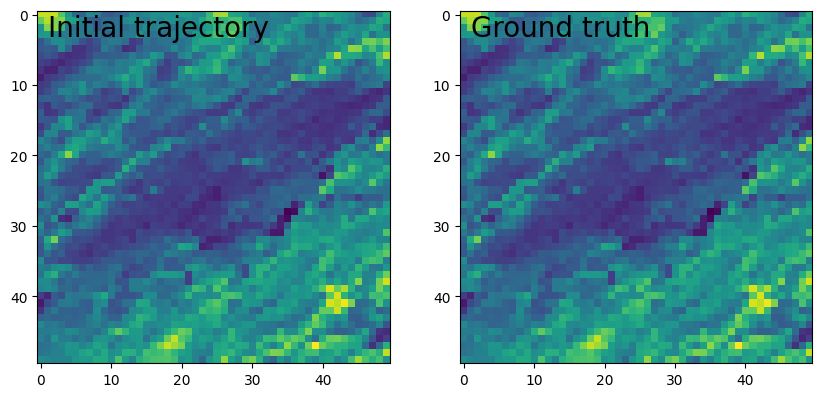

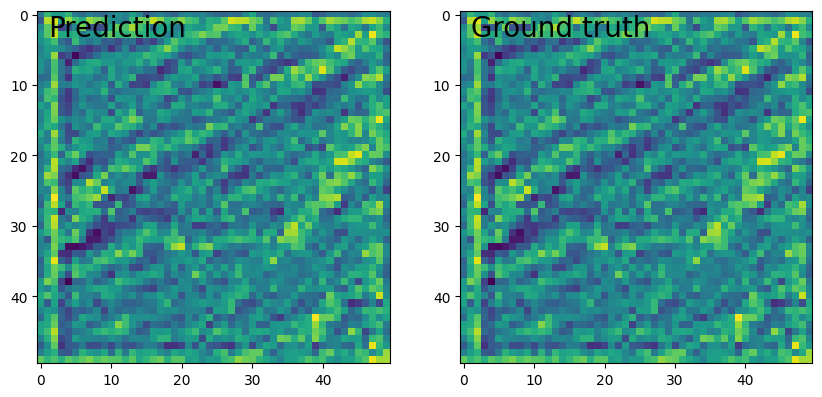

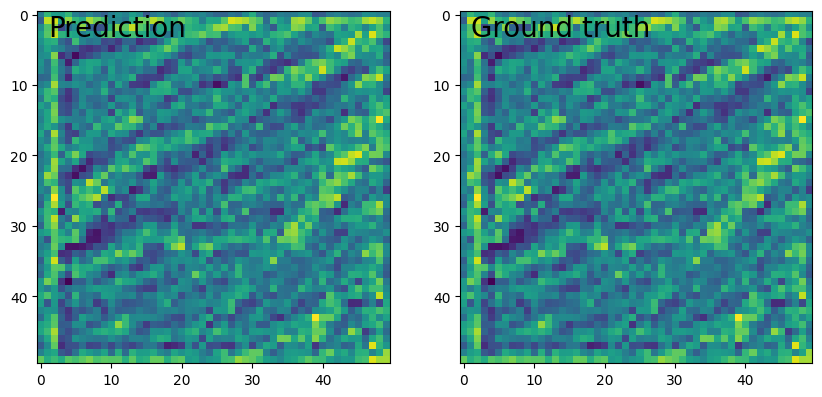

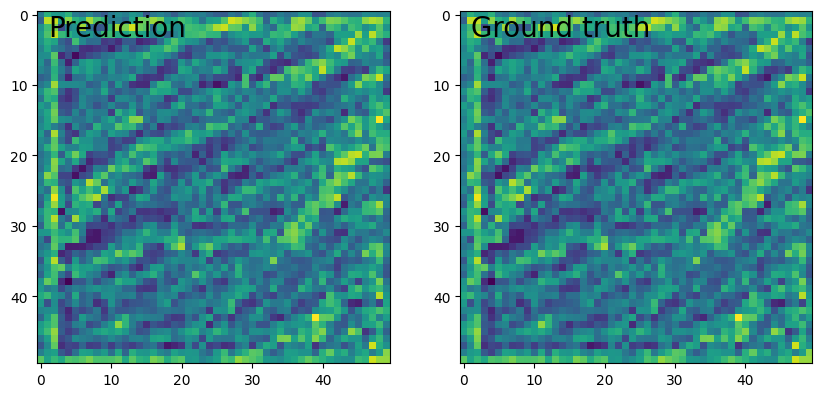

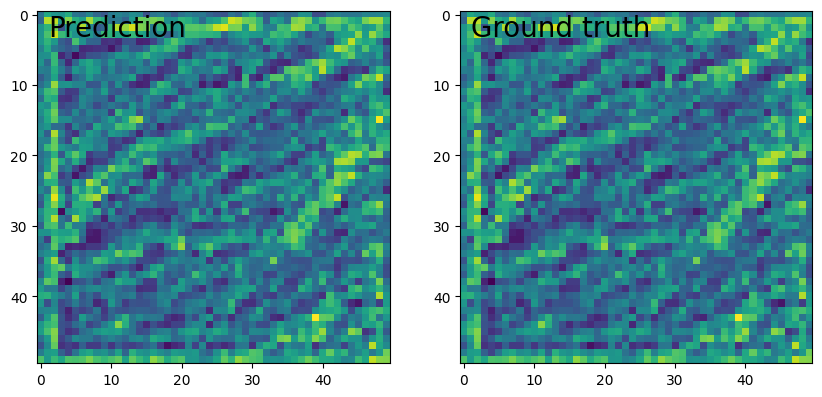

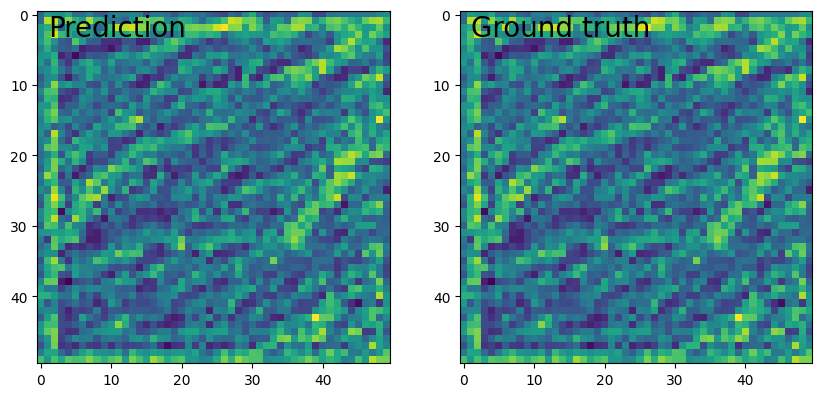

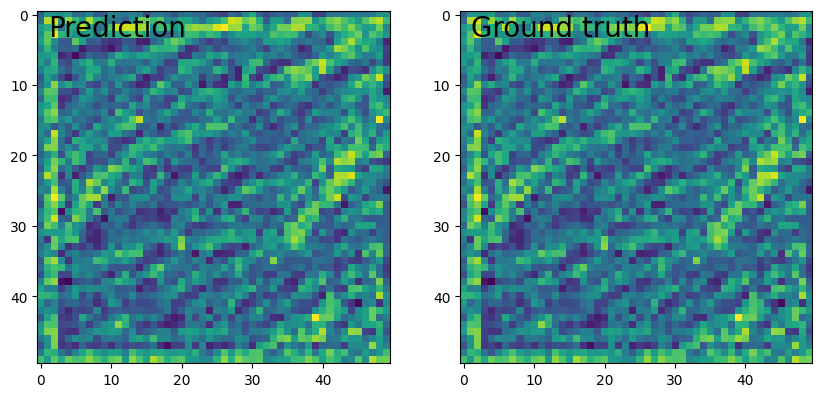

In [19]:
track = data[idx][:, :, :, 1]
print(track.shape)

for i in range(len(track)):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= steps:
        ax.text(1, 3, 'Prediction', fontsize=20)
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = preds[i, :, :, :]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    plt.imshow(toplot)

1/1 [==============================] - 0s 92ms/step


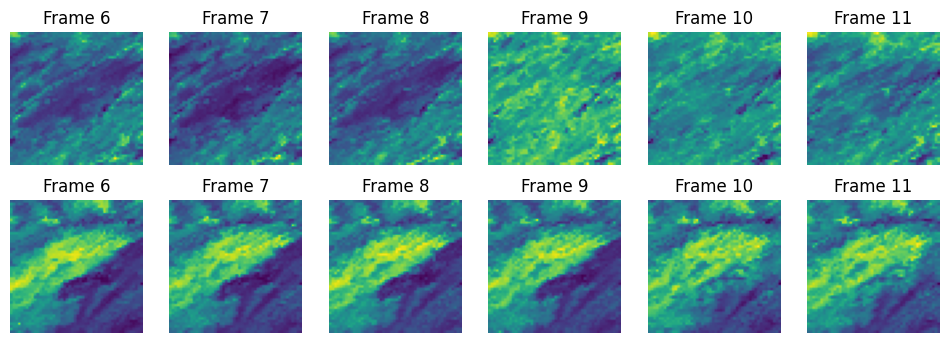

In [20]:
for _ in range(6):
    # Extract the model's prediction and post-process it.
    new_prediction = seq.predict(np.expand_dims(during[idx], axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((during[idx], predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 6, figsize=(12, 4))

# Plot the original frames.
for it, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(after[idx][it]))
    ax.set_title(f"Frame {it + 6}")
    ax.axis("off")

# Plot the new frames.
new_frames = after[6:, ...]
for it, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx][it]))
    ax.set_title(f"Frame {it + 6}")
    ax.axis("off")

# Display the figure.
plt.show()